In [1]:
%cd learners

/home/buehrle/dev/InteractionImitation/scratch/etienne/pillbox/learners


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

In [6]:
import torch
import gym
from intersim.utils import get_map_path, get_svt, SVT_to_stateactions

def data_sa(loc=0, track=0, actions=None):
    """Use given actions or compute using `SVT_to_stateactions`."""
    
    svt, svt_path = get_svt(loc, track)
    osm = get_map_path(loc)
    
    if actions is None:
        _, actions = SVT_to_stateactions(svt)
        
    nna_observations = []
    nna_actions = []
    
    env = gym.make('intersim:intersim-v0', svt=svt, map_path=osm)
    obs, info = env.reset()
    for action in tqdm(actions):
        relative_state = torch.stack((
            obs['relative_state'][..., 0],
            obs['relative_state'][..., 1],
            (obs['relative_state'][..., 2]**2 + obs['relative_state'][..., 3]**2).sqrt(),
            obs['relative_state'][..., 4],
            obs['relative_state'][..., 5],
        ), -1)
        observations = torch.cat((
            obs['state'].unsqueeze(-2),
            relative_state,
        ), -2)
        
        nna = ~(observations.isnan().all(-1).all(-1))
        nna_observations.append(observations[nna])
        nna_actions.append(action[nna])
        
        obs, r, done, info = env.step(action)
        assert not done, 'Episode terminated during expert demonstration.'
    
    observations = torch.cat(nna_observations)
    actions = torch.cat(nna_actions)
    return observations, actions

In [7]:
def simactions(loc, track, mu):
    """Compute simactions using `env.target_state`."""
    svt, svt_path = get_svt(loc, track)
    osm = get_map_path(loc)
    actions = []
    
    env = gym.make('intersim:intersim-v0', svt=svt, map_path=osm)
    obs, info = env.reset()
    for s in tqdm(svt.simstate[1:]):
        obs, r, done, info = env.step(env.target_state(s, mu))
        actions.append(info['action_taken'])
    
    return torch.stack(actions)

In [7]:
smooth_actions = simactions(loc=0, track=0, mu=.01)
smooth_actions.shape

Custom Vehicle Trajectory Paths
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset


torch.Size([3006, 151, 1])

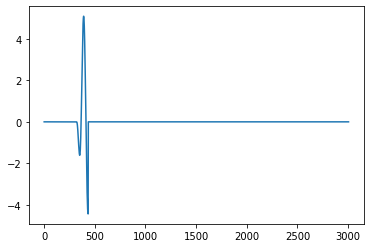

In [8]:
plt.plot(smooth_actions[:, 20, 0])

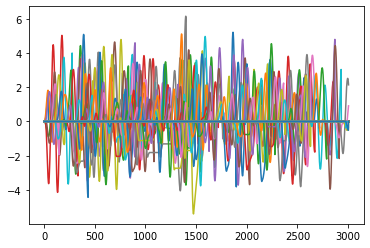

In [9]:
for act in smooth_actions[:, :, 0].transpose(0, 1):
    plt.plot(act)

In [10]:
smooth_observations2, smooth_actions2 = data_sa(loc=0, track=0, actions=smooth_actions)

Custom Vehicle Trajectory Paths
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset


/tmp/ipykernel_25334/2885851852.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs)


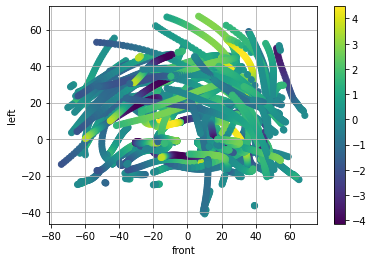

In [15]:
state_distribution(zip(smooth_observations2[:1000], smooth_actions2[:1000]))
plt.grid()

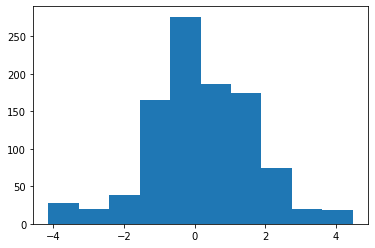

In [62]:
action_distribution(zip(smooth_observations2, smooth_actions2))

In [ ]:
from intersim.utils import get_svt, SVT_to_stateactions
svt, svt_path = get_svt(loc=0, track=0)
states, actions = SVT_to_stateactions(svt)
print(actions.shape)

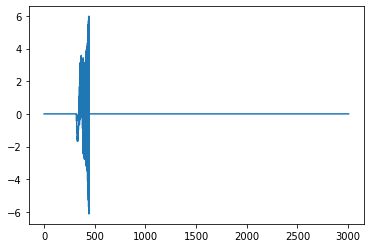

In [20]:
plt.plot(actions[:, 20, 0])

In [ ]:
for act in actions[:, :, 0].transpose(0, 1):
    plt.plot(act)

In [41]:
data_observations, data_actions = data_sa()

Custom Vehicle Trajectory Paths
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset
Time: 13.6. Warning: requested action outside of bounds, being clamped
Time: 13.700000000000001. Warning: requested action outside of bounds, being clamped
Time: 13.8. Warning: requested action outside of bounds, being clamped
Time: 13.9. Warning: requested action outside of bounds, being clamped
Time: 14.0. Warning: requested action outside of bounds, being clamped
Time: 14.1. Warning: requested action outside of bounds, being clamped
Time: 14.200000000000001. Warning: requested action outside of bounds, being clamped
Time: 14.3. Warning: requested action outside of bounds, being clamped
Time: 14.4. Warning: requested action outside of bounds, being clamped
Time: 14.5. Warning: requested action outside of bounds, being clamped
Time: 14.6. Warning: requested action outside of bounds, being clamped
Time: 14.700000000000001. Warning: requested action outside of bounds, being clamped
Time: 1

In [61]:
ego_observations = obs_to_ego_frame(data_observations)

/tmp/ipykernel_31031/2885851852.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs)


In [62]:
print(ego_observations.shape)
print(data_actions.shape)

torch.Size([38600, 151, 5])
torch.Size([38600, 1])


In [63]:
ext_actions = data_actions.repeat(1, ego_observations.shape[-2])
print(ext_actions.shape)

torch.Size([38600, 151])


In [64]:
flat_observations = ego_observations.reshape(-1, ego_observations.shape[-1])
flat_actions = ext_actions.reshape(-1)
print(flat_observations.shape)
print(flat_actions.shape)

torch.Size([5828600, 5])
torch.Size([5828600])


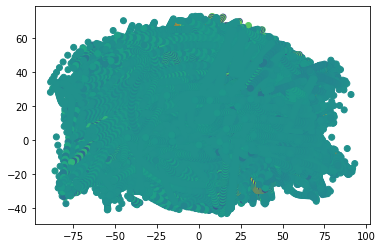

In [66]:
plt.scatter(
    flat_observations[:, 0],
    flat_observations[:, 1],
    c=flat_actions
)
plt.colorbar()
plt.grid()

In [8]:
def demo_sa(demo):
    num_trajs = demo['num_trajs']
    for t in range(num_trajs):
        traj = demo[str(t)].item()
        for o, a in zip(traj['states'], traj['actions']):
            yield o, a

In [9]:
import gym
from tqdm import tqdm

def policy_sa(pi, max_steps=1000, mode=None):
    env = gym.make('intersim:intersim-v0')
    env.reset() # obs = env.reset()
    obs, _, done, _ = env.step(0 * env.action_space.sample())
    
    _except = lambda o, i: torch.cat((o[:i], o[i+1:]))
    
    _relative_state_v = lambda obs: torch.stack((
        obs[..., 0],
        obs[..., 1],
        (obs[..., 2]**2 + obs[..., 3]**2).sqrt(),
        obs[..., 4],
        obs[..., 5],
    ), -1)
    
    for _ in tqdm(range(max_steps)):
        pi_obs = torch.stack(tuple(
            torch.cat((e.unsqueeze(0), _relative_state_v(_except(o, i))))
            for i, (e, o) in enumerate(zip(obs['state'], obs['relative_state']))
        ))
        
        actions = pi(pi_obs)
        
        yield from zip(pi_obs, actions)
        
        obs, _, done, _ = env.step(actions)
        
        env.render(mode=mode)
            
        if done:
            break

    env.close()

In [10]:
import torch

def obs_to_ego_frame(obs):
    obs = torch.tensor(obs)
    ego = obs[..., 0, :]
    rel = obs[..., 1:, :]

    front = torch.stack((torch.cos(ego[..., 3]), torch.sin(ego[..., 3])), -1)
    left = torch.stack((-torch.sin(ego[..., 3]), torch.cos(ego[..., 3])), -1)
    df = (rel[..., :2] * front.unsqueeze(-2)).sum(-1)
    dl = (rel[..., :2] * left.unsqueeze(-2)).sum(-1)
    #d = (rel[..., :2] ** 2).sum(-1).sqrt()
    #alpha = torch.atan2(dl, df)

    rel[..., 0] = df
    rel[..., 1] = dl
    
    return rel

In [11]:
def state_distribution(sa):
    front = []
    left = []
    action = []
    
    for o, a in sa:
        o = obs_to_ego_frame(o)
        nan = o.isnan().any(-1)
        o = o[~nan]
        
        front.extend(map(float, o[:, 0]))
        left.extend(map(float, o[:, 1]))
        action.extend([float(a)] * len(o))
        
    plt.scatter(front, left, c=action)
    plt.xlabel('front')
    plt.ylabel('left')
    plt.colorbar()
    plt.grid()

In [12]:
def action_distribution(sa):
    action = []
    for _, a in sa:
        action.append(float(a))
    plt.hist(action)

In [13]:
import numpy as np

In [14]:
state_distribution(demo_sa(np.load('../experts/intersim:intersim-v0/demos.npz', allow_pickle=True)))

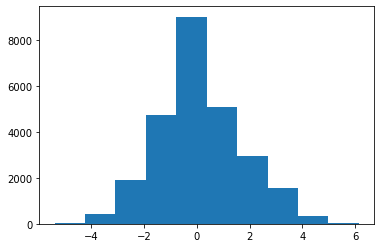

In [17]:
action_distribution(demo_sa(np.load('../experts/intersim:intersim-v0/demos.npz', allow_pickle=True)))

In [18]:
def trajectory_actions(demos):
    for i in range(demos['num_trajs']):
        actions = demos[str(i)].item()['actions'].squeeze()
        plt.plot(actions)

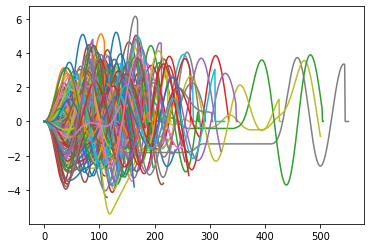

In [20]:
trajectory_actions(np.load('../experts/intersim:intersim-v0/demos.npz', allow_pickle=True))

In [11]:
from intersim_advil import IntersimPolicy
pi = IntersimPolicy(env=None)
pi.load_state_dict(torch.load('intersim:intersim-v0/advil_policy.pt'))

<All keys matched successfully>

Vehicle Trajectory Paths: datasets/trackfiles/DR_USA_Roundabout_FT/vehicle_tracks_000.csv
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset


  0%|                                                                                                                   | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_934/2885851852.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  6.91it/s]


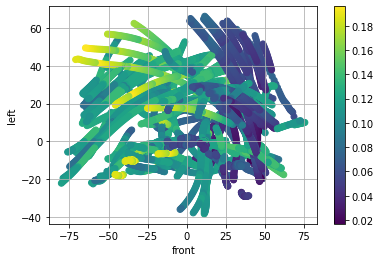

In [17]:
state_distribution(policy_sa(pi, max_steps=200))

Vehicle Trajectory Paths: datasets/trackfiles/DR_USA_Roundabout_FT/vehicle_tracks_000.csv
Map Path: datasets/maps/DR_USA_Roundabout_FT.osm
Environment Reset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.28it/s]


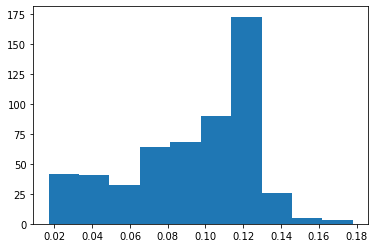

In [18]:
action_distribution(policy_sa(pi, max_steps=100))